In [85]:
import cv2
import json
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

logs = []

In [186]:
# Assigned hyperparameter: number of training images
# Different values for the maximum number of images per condition
N1 = 5
N2 = 50
N3 = 90
N4 = 125
N5 = 200
N6 = 250

# Set the maximum number of images per condition
MAX_PER_CONDITION = N6

# Fewer training images will likely lead to lower prediction accuracy and higher risk of overfitting. As the number of
# training images increases, I expect accuracy and generalization to improve, but only up to a certain point. I believe that
# this point lies beyond the maximum of 250 total images per class we are using here. Increasing the number of training
# images will also increase the time it takes to train the model. However, the time it takes for the model to make predictions
# will remain unaffected.

# To investigate the effect of the number of training images on prediction accuracy and inference time, I will log accuracy and
# loss for both training and validation as well as inference time and the average inference time per image.

## helper function to load and parse annotations

In [187]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'../gesture_dataset_sample/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

## helper function to pre-process images (color channel conversion and resizing)

In [188]:
def preprocess_image(img):
    if img is None or img.size == 0:
        return None 
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [189]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    
    # Get filenames and truncate to MAX_PER_CONDITION
    all_filenames = os.listdir(f'../gesture_dataset_sample/{condition}')
    limited_filenames = all_filenames[:MAX_PER_CONDITION]

    for filename in tqdm(limited_filenames):
        UID = filename.split('.')[0]
        img = cv2.imread(f'../gesture_dataset_sample/{condition}/{filename}')

        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue

       # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

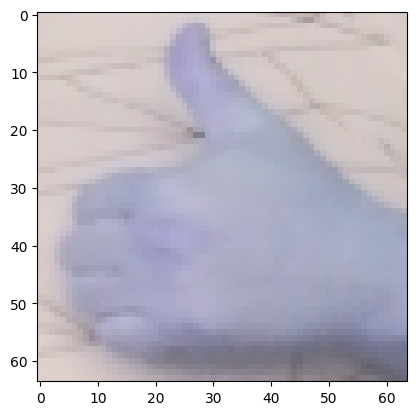

In [190]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [191]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [192]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


In [193]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

C:\Users\leean\OneDrive\Documents\UR\Master\ITT\5\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## now, we can train the model using the fit() function
## this will take a while

In [194]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.4126 - loss: 1.0830 - val_accuracy: 0.3516 - val_loss: 1.4812 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 0.3949 - loss: 1.1486 - val_accuracy: 0.4766 - val_loss: 1.0616 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4875 - loss: 0.9922 - val_accuracy: 0.5781 - val_loss: 0.8465 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6915 - loss: 0.7653 - val_accuracy: 0.6875 - val_loss: 0.6988 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 115ms/step - accuracy: 0.7306 - loss: 0.6471 - val_accuracy: 0.8438 - val_loss: 0.4346 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - accuracy: 0.8930 - loss: 0.3102 - val_accuracy: 0.8047 - val_loss: 0.5344 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 7s 111ms/step - accuracy: 0.8844 - loss: 0.3046 - v

In [195]:
# let's have a look at our model
model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip_10 (RandomFlip)          │ (8, 64, 64, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast_10 (RandomContrast)  │ (8, 64, 64, 3)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (8, 64, 64, 64)             │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (8, 16, 16, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (8, 16, 16, 32)             │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (8, 6, 6, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (8, 6, 6, 32)               │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (8, 3, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (8, 3, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (8, 288)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (8, 64)                     │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (8, 64)                     │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (8, 3)                      │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,843 (1.13 MB)

 Trainable params: 98,947 (386.51 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 197,896 (773.04 KB)

## Plot accuracy and loss of the training process

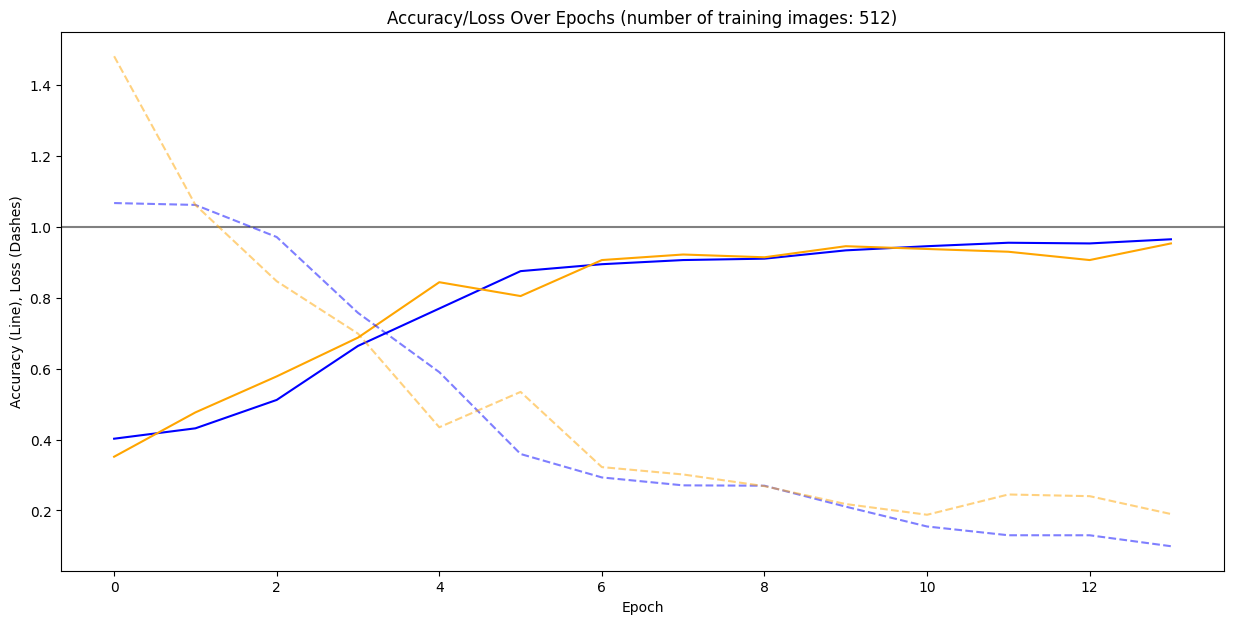

In [196]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

plt.title(f'Accuracy/Loss Over Epochs (number of training images: {len(X_train)})')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)
plt.savefig(f'accuracy_plot_{len(X_train)}.png', dpi=300, bbox_inches='tight')

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [197]:
model.save(f"gesture_recognition_{MAX_PER_CONDITION}.keras")

# and this is how you load the model
# model = keras.models.load_model(f"gesture_recognition_{MAX_PER_CONDITION}.keras")

## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step


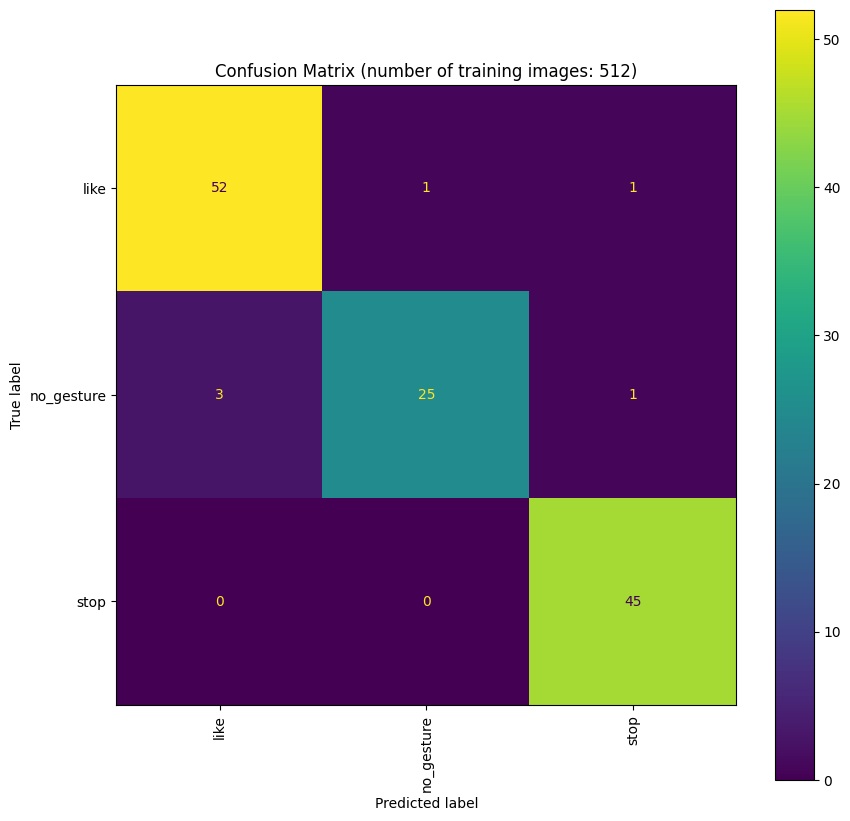

In [210]:
start_time = time.time()

# let the model make predictions for our training data
y_predictions = model.predict(X_test)

end_time = time.time()
inference_time = end_time - start_time
avg_inference_time = inference_time / len(X_test)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

# create and plot confusion matrix
labels = list(range(len(label_names)))

conf_matrix = confusion_matrix(y_test, y_predictions, labels=labels)

fig = plt.figure(figsize=(10, 10))
plt.title(f'Confusion Matrix (number of training images: {len(X_train)})')

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
plt.savefig(f'conf_matrix_{len(X_train)}.png', dpi=300, bbox_inches='tight')
pass

In [199]:
accuracy = history.history['accuracy'][-1]
loss = history.history['loss'][-1]
val_accuracy = history.history['val_accuracy'][-1]
val_loss = history.history['val_loss'][-1]

logs.append({
    "MAX_PER_CONDITION": MAX_PER_CONDITION,
    "training_images": len(X_train),
    "accuracy": accuracy,
    "loss": loss,
    "val_accuracy": val_accuracy,
    "val_loss": val_loss,
    "inference_time": inference_time,
    "avg_inference_time": avg_inference_time
})

In [211]:
for log in logs:
    print(log)

{'MAX_PER_CONDITION': 5, 'training_images': 9, 'accuracy': 0.3333333432674408, 'loss': 1.1415332555770874, 'val_accuracy': 0.6666666865348816, 'val_loss': 0.8838462829589844, 'inference_time': 0.6454110145568848, 'avg_inference_time': 0.21513700485229492}
{'MAX_PER_CONDITION': 50, 'training_images': 107, 'accuracy': 0.4112149477005005, 'loss': 1.0515284538269043, 'val_accuracy': 0.29629629850387573, 'val_loss': 1.0745824575424194, 'inference_time': 0.8332912921905518, 'avg_inference_time': 0.030862640451501916}
{'MAX_PER_CONDITION': 90, 'training_images': 188, 'accuracy': 0.9468085169792175, 'loss': 0.13826441764831543, 'val_accuracy': 0.936170220375061, 'val_loss': 0.15799234807491302, 'inference_time': 1.5045652389526367, 'avg_inference_time': 0.0320120263606944}
{'MAX_PER_CONDITION': 125, 'training_images': 263, 'accuracy': 0.9695817232131958, 'loss': 0.09214339405298233, 'val_accuracy': 0.939393937587738, 'val_loss': 0.2004004865884781, 'inference_time': 1.3599975109100342, 'avg_in

# Results

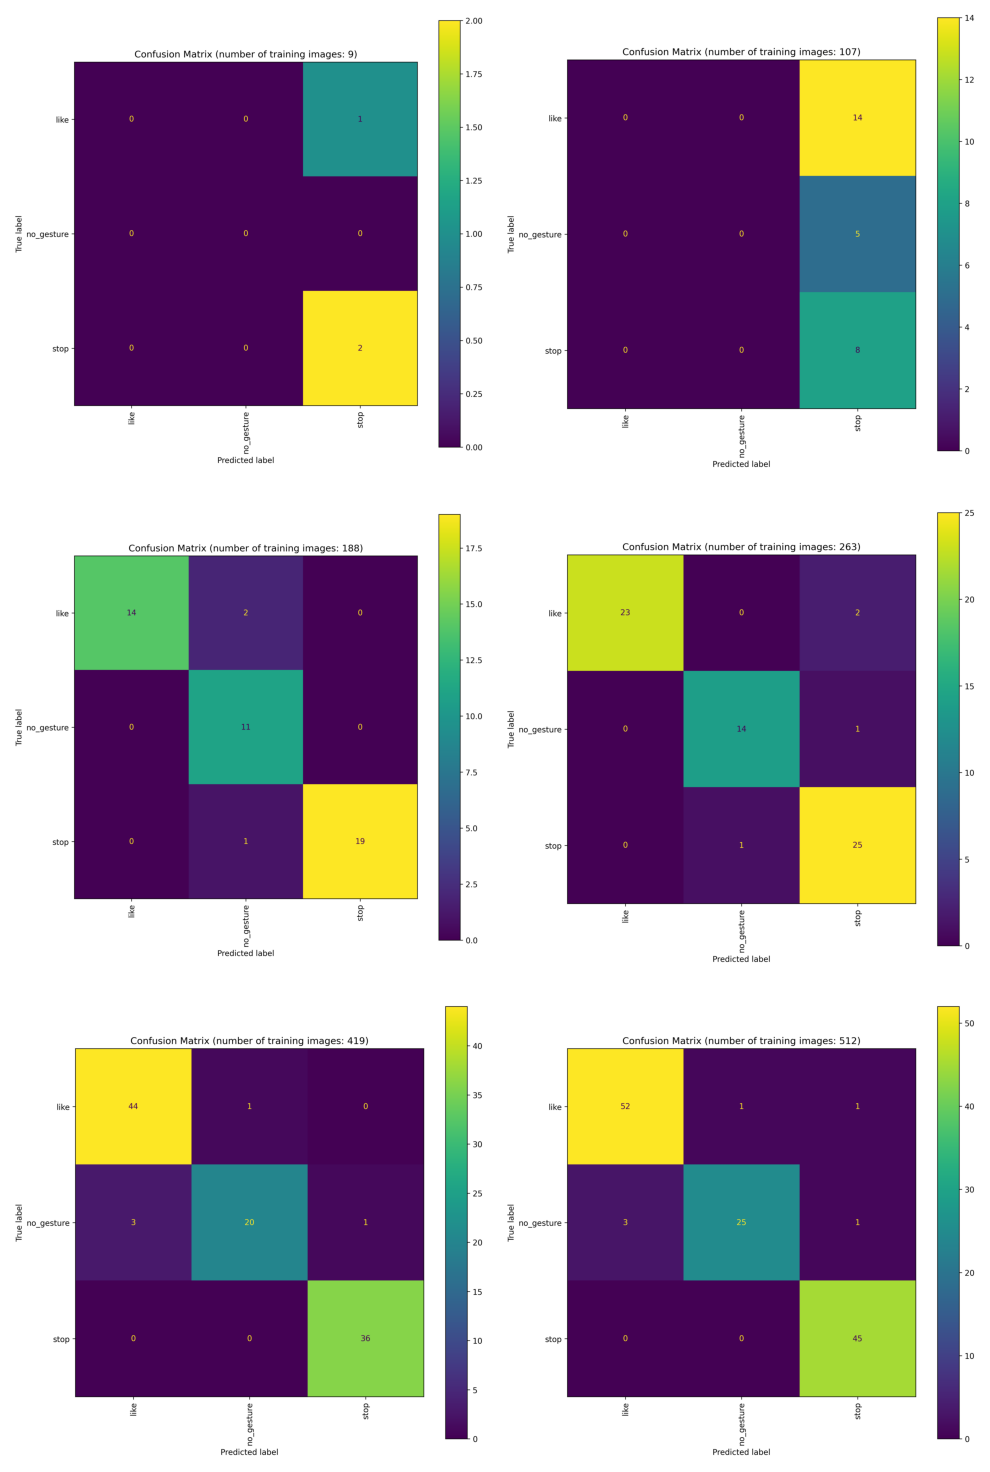

In [206]:
# Confusion matrices for all values

image_paths = ['conf_matrix_9.png', 'conf_matrix_107.png', 'conf_matrix_188.png', 'conf_matrix_263.png', 'conf_matrix_419.png', 'conf_matrix_512.png']

cols = 2
rows = (len(image_paths) + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
axs = axs.flatten() if rows > 1 else axs

for i, path in enumerate(image_paths):
    axs[i].imshow(mpimg.imread(path))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

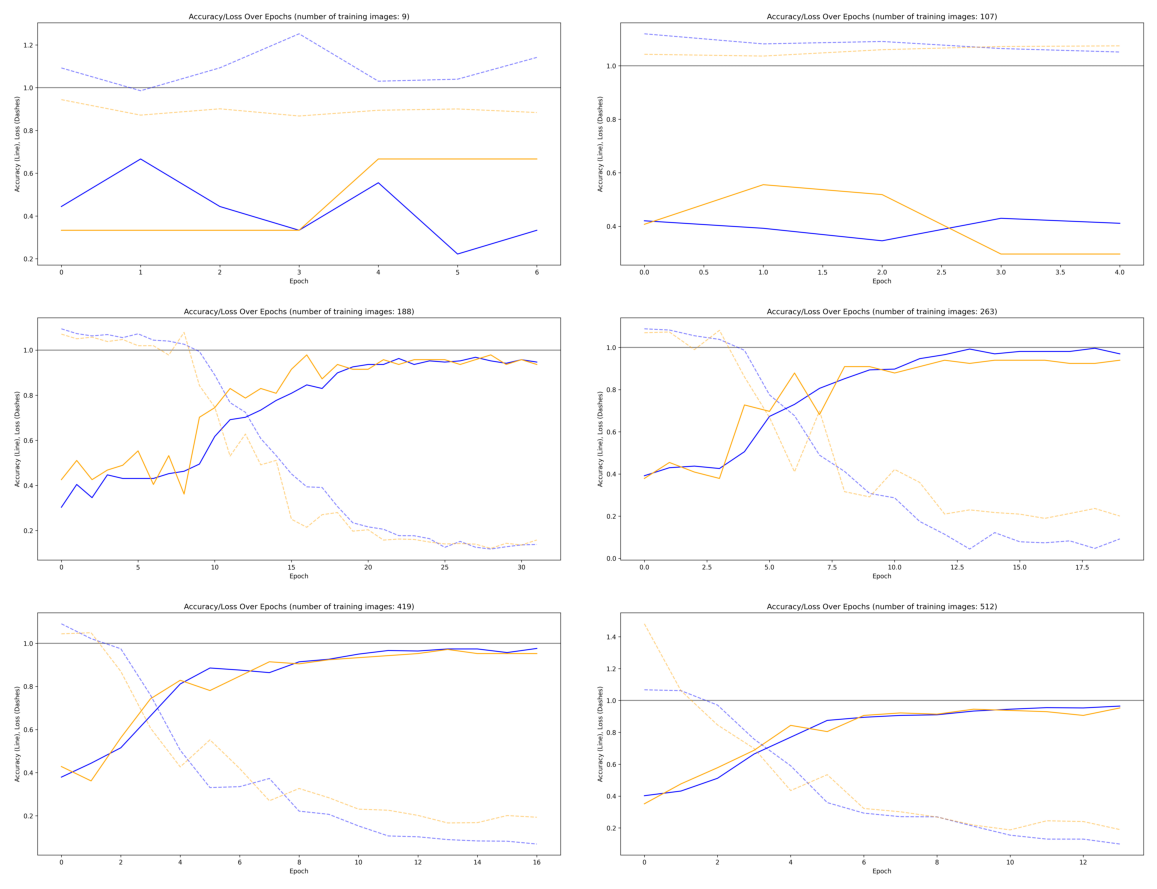

In [207]:
image_paths = ['accuracy_plot_9.png', 'accuracy_plot_107.png', 'accuracy_plot_188.png', 'accuracy_plot_263.png', 'accuracy_plot_419.png', 'accuracy_plot_512.png']

cols = 2
rows = (len(image_paths) + cols - 1) // cols

fig, axs = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))
axs = axs.flatten() if rows > 1 else axs

for i, path in enumerate(image_paths):
    axs[i].imshow(mpimg.imread(path))
    axs[i].axis('off')

plt.tight_layout()
plt.show()

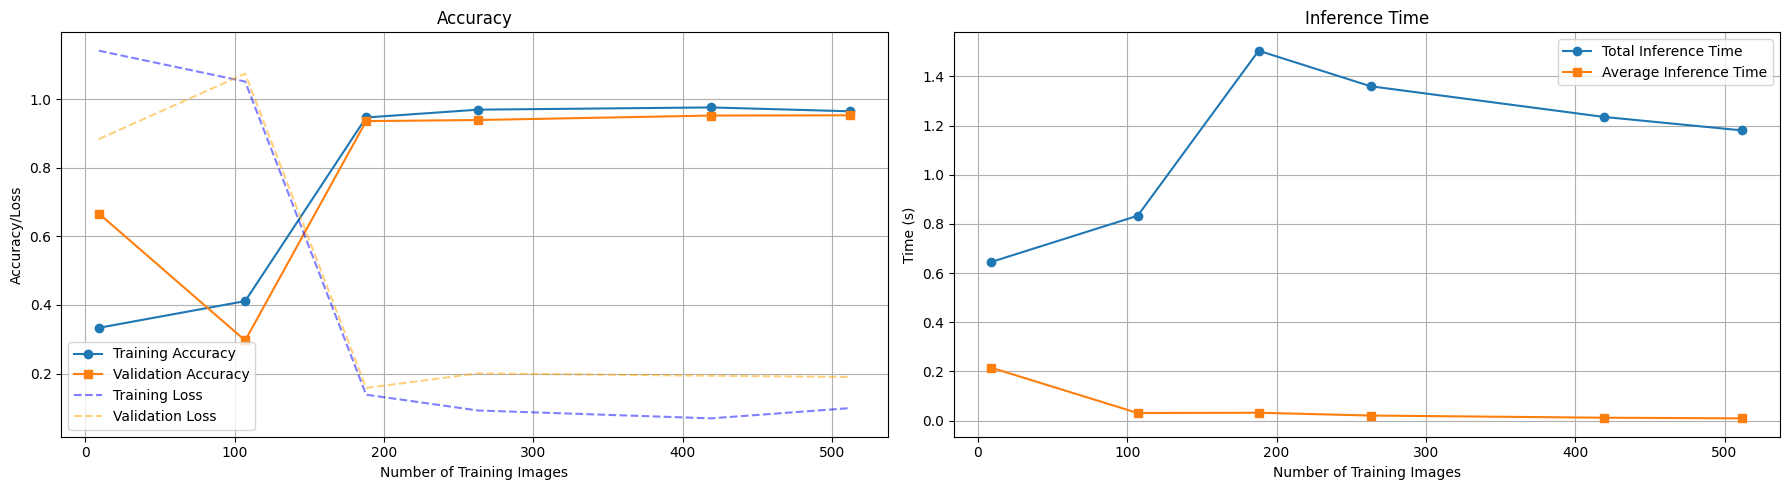

In [208]:
training_sizes = [log["training_images"] for log in logs]
acc = [log["accuracy"] for log in logs]
val_acc = [log["val_accuracy"] for log in logs]
loss = [log["loss"] for log in logs]
val_loss = [log["val_loss"] for log in logs]
inference_time = [log["inference_time"] for log in logs]
avg_inference_time = [log["avg_inference_time"] for log in logs]

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Accuracy plot
axs[0].plot(training_sizes, acc, marker='o', label='Training Accuracy')
axs[0].plot(training_sizes, val_acc, marker='s', label='Validation Accuracy')
axs[0].plot(training_sizes, loss, '--', color='blue', alpha=0.5, label='Training Loss')
axs[0].plot(training_sizes, val_loss, '--', color='orange', alpha=0.5, label='Validation Loss')
axs[0].set_title('Accuracy')
axs[0].set_xlabel('Number of Training Images')
axs[0].set_ylabel('Accuracy/Loss')
axs[0].legend()
axs[0].grid(True)

# Inference time plot
axs[1].plot(training_sizes, inference_time, marker='o', label='Total Inference Time')
axs[1].plot(training_sizes, avg_inference_time, marker='s', label='Average Inference Time')
axs[1].set_title('Inference Time')
axs[1].set_xlabel('Number of Training Images')
axs[1].set_ylabel('Time (s)')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [209]:
# As expected, prediction accuracy increased with the number of training images. However, training accuracy appeared to stagnate
# before reaching 250 images per condition, with little improvement between 90 and 250 images (or 188 and 512 total training images).

# Contrary to my expectations, the number of training images also appeared to affect inference time for predictions. While the average
# inference time per image remained relatively stable, the total inference time increased with training size, peaking at 188 training
# images before dropping again slighty. This may be due to more efficient inference behavior in better-trained models.